In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchtext
import os
import tarfile
from PIL import Image
import torchvision
from random import randint
from scipy import ndimage
from skimage.transform import resize
import urllib.request
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import feature, filters
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import resize
from random import randint
from copy import deepcopy
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
torch.autograd.set_detect_anomaly(True)

###Opens and saves images to array

In [ ]:
#from google.colab import drive
#drive.mount("/content/drive")
from google.colab import files
uploaded = files.upload()

Saving test1_color.JPG to test1_color.JPG
Saving test1_outline.JPG to test1_outline.JPG


In [ ]:
uploaded

NameError: ignored

In [ ]:
path = r'/content'
file_names = os.listdir(path)[1:1200]

output_list = list()
for file_name in file_names:
    img = resize(np.array(Image.open(path+'/'+ file_name)),(286,286,3))
    output_list.append(img)


In [ ]:
input_list = list()
for i in output_list:
    edge = feature.canny(i[:,:,0]*0.3+i[:,:,1]*0.587+i[:,:,2]*0.114, sigma=2)
    input_list.append(edge)

NameError: ignored

###Preprocess Images


In [ ]:
for image_num in range(len(input_list)):
  #resize
  input_list[image_num] = resize(input_list[image_num],(286,286,1))
  output_list[image_num] = resize(output_list[image_num],(286,286,3))

  #normalize
  #input_list[image_num] = input_list[image_num]/127.5 - 1
  #output_list[image_num] = output_list[image_num]/127.5 - 1



In [ ]:
#color info
blur_list = list()
for i in output_list:
    blur = deepcopy(i)
    for j in range(35):
        pos_x = randint(0,255)
        pos_y = randint(0,255)
        for k in range(2):
            for l in range(2):
                blur[pos_x-k][pos_y-l][0] = 255
                blur[pos_x-k][pos_y-l][1] = 255
                blur[pos_x-k][pos_y-l][2] = 255
    blur =  ndi.uniform_filter(blur, size=(50, 50, 1))       
    blur =  ndi.uniform_filter(blur, size=(90, 90, 1)) 
    blur_list.append(blur)

In [ ]:
def white_out(a):
    r = deepcopy(a)
    for j in range(35):
        pos_x = randint(0,255)
        pos_y = randint(0,255)
        for k in range(2):
            for l in range(2):
                r[pos_x-k][pos_y-l][0] = 255
                r[pos_x-k][pos_y-l][1] = 255
                r[pos_x-k][pos_y-l][2] = 255
    r =  ndi.uniform_filter(r, size=(50, 50, 1))       
    r =  ndi.uniform_filter(r, size=(90, 90, 1)) 
    return r

In [ ]:
processed_input = list()
processed_output = list()
processed_blur = list()
for image_num in range(len(input_list)):
  for i in range(4):
    rand_crop_x = randint(0,20)
    rand_crop_y = randint(0,20)
    if randint(0,100) < 50:
      processed_input.append(np.fliplr(input_list[image_num][rand_crop_x:rand_crop_x + 256,rand_crop_y:rand_crop_y + 256, :]))
      processed_output.append(np.fliplr(output_list[image_num][rand_crop_x:rand_crop_x + 256,rand_crop_y:rand_crop_y + 256, :]))
      processed_blur.append(np.fliplr(blur_list[image_num][rand_crop_x:rand_crop_x + 256,rand_crop_y:rand_crop_y + 256, :]))
    else:
      processed_input.append(input_list[image_num][rand_crop_x:rand_crop_x + 256,rand_crop_y:rand_crop_y + 256, :])
      processed_output.append(output_list[image_num][rand_crop_x:rand_crop_x + 256,rand_crop_y:rand_crop_y + 256, :])
      processed_blur.append(blur_list[image_num][rand_crop_x:rand_crop_x + 256,rand_crop_y:rand_crop_y + 256, :])


In [ ]:
#del input_list
#del output_list
#del blur_list 

nn_input = list()
nn_output = list()
for image_num in range(len(processed_input)):
  nn_output.append([processed_output[image_num][:,:,0],processed_output[image_num][:,:,1],processed_output[image_num][:,:,2]])
  nn_input.append([processed_input[image_num][:,:,0],processed_blur[image_num][:,:,0],processed_blur[image_num][:,:,1],processed_blur[image_num][:,:,2]])

nn_input = torch.from_numpy(np.array(nn_input)).float() * 2 - 1
nn_output = torch.from_numpy(np.array(nn_output)).float() * 2 - 1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

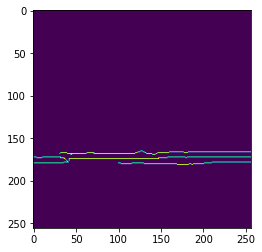

In [ ]:
plt.imshow((processed_input[1][:,:,0] > 0.5).astype(int))
(processed_input[1][:,:,0] > 0.5).astype(int)

###Defining Generator

In [ ]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.dropout = nn.Dropout2d(0.5)
        #Downsampling
        self.conv1 = nn.Conv2d(4,64, 4, stride=2, padding = 1,bias=False)
        nn.init.normal_(self.conv1.weight,mean=0, std=0.02)
        self.conv2 = nn.Conv2d(64,128, 4, stride=2, padding =  1,bias=False)
        nn.init.normal_(self.conv2.weight,mean=0, std=0.02)
        self.norm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128,256, 4, stride=2, padding = 1,bias=False)
        nn.init.normal_(self.conv3.weight,mean=0, std=0.02)
        self.norm3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256,512, 4, stride=2, padding = 1,bias=False)
        nn.init.normal_(self.conv4.weight,mean=0, std=0.02)
        self.norm4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512,512, 4, stride=2, padding = 1,bias=False)
        nn.init.normal_(self.conv5.weight,mean=0, std=0.02)
        self.norm5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512,512, 4, stride=2, padding = 1,bias=False)
        nn.init.normal_(self.conv6.weight,mean=0, std=0.02)
        self.norm6 = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512,512, 4, stride=2, padding = 1,bias=False)
        nn.init.normal_(self.conv7.weight,mean=0, std=0.02)
        self.norm7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512,512, 4, stride=2, padding = 1,bias=False)
        nn.init.normal_(self.conv8.weight,mean=0, std=0.02)
        self.norm8 = nn.BatchNorm2d(512)
        #Upsampling
        self.conv9 = nn.ConvTranspose2d(512, 512, 4, stride=2, padding = 1,bias=False)
        nn.init.normal_(self.conv9.weight, mean=0, std=0.02)
        self.norm9 = nn.BatchNorm2d(512)
        self.conv10 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding = 1,bias=False)
        nn.init.normal_(self.conv10.weight,mean=0, std=0.02)
        self.norm10 = nn.BatchNorm2d(512)
        self.conv11 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding = 1,bias=False)
        nn.init.normal_(self.conv11.weight,mean=0, std=0.02)
        self.norm11 = nn.BatchNorm2d(512)
        self.conv12 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding = 1,bias=False)
        nn.init.normal_(self.conv12.weight,mean=0, std=0.02)
        self.norm12 = nn.BatchNorm2d(512)
        self.conv13 = nn.ConvTranspose2d(1024, 256, 4, stride=2, padding = 1,bias=False)
        nn.init.normal_(self.conv13.weight,mean=0, std=0.02)
        self.norm13 = nn.BatchNorm2d(256)
        self.conv14 = nn.ConvTranspose2d(512, 128, 4, stride=2, padding = 1,bias=False)
        nn.init.normal_(self.conv14.weight,mean=0, std=0.02)
        self.norm14 = nn.BatchNorm2d(128)
        self.conv15 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding = 1,bias=False)
        nn.init.normal_(self.conv15.weight,mean=0, std=0.02)
        self.norm15 = nn.BatchNorm2d(64)
        self.conv16 = nn.ConvTranspose2d(128, 3, 4, stride=2, padding = 1)
        nn.init.normal_(self.conv1.weight,mean=0, std=0.02)
    def forward(self, x):
      #Downsampling
      s1 = F.leaky_relu(self.conv1(x))
      s1 = self.dropout(s1)
      s2 = F.leaky_relu(self.norm2(self.conv2(s1)))
      s2 = self.dropout(s2)
      s3 = F.leaky_relu(self.norm3(self.conv3(s2)))
      s3 = self.dropout(s3)
      s4 = F.leaky_relu(self.norm4(self.conv4(s3)))
      s5 = F.leaky_relu(self.norm5(self.conv5(s4)))
      s6 = F.leaky_relu(self.norm6(self.conv6(s5)))
      s7 = F.leaky_relu(self.norm7(self.conv7(s6)))
      s8 = F.leaky_relu(self.conv8(s7))

      #Upsampling
      s7_1 = F.relu(self.norm9(self.conv9(s8)))
      s6_1 = F.relu(self.norm10(self.conv10(torch.cat((s7,s7_1),1))))
      s5_1 = F.relu(self.norm11(self.conv11(torch.cat((s6,s6_1),1))))
      s4_1 = F.relu(self.norm12(self.conv12(torch.cat((s5,s5_1),1))))
      s3_1 = F.relu(self.norm13(self.conv13(torch.cat((s4,s4_1),1))))
      s3_1 = self.dropout(s3_1)
      s2_1 = F.relu(self.norm14(self.conv14(torch.cat((s3,s3_1),1))))
      s2_1 = self.dropout(s2_1)
      s1_1 = F.relu(self.norm15(self.conv15(torch.cat((s2,s2_1),1))))
      s1_1 = self.dropout(s1_1)
      s0 = F.tanh(self.conv16(torch.cat((s1,s1_1),1)))
      return s0

In [ ]:
#sample_image = Generator(nn_input[:1])
#plt.imshow(sample_image[0][2].detach().numpy())

###Defining Discriminator

In [ ]:
class Net2(nn.Module):
    def __init__(self):
      super(Net2, self).__init__()
      self.conv1 = nn.Conv2d(7,64, 4, stride=2, padding = 1, bias=False)
      nn.init.normal_(self.conv1.weight,mean=0, std=0.02)
      self.conv2 = nn.Conv2d(64,128, 4, stride=2, padding =  1, bias=False)
      nn.init.normal_(self.conv2.weight,mean=0, std=0.02)
      self.norm2 = nn.BatchNorm2d(128)
      self.conv3 = nn.Conv2d(128,256, 4, stride=2, padding =  1, bias=False)
      nn.init.normal_(self.conv3.weight,mean=0, std=0.02)
      self.norm3 = nn.BatchNorm2d(256)
      self.conv4 = nn.Conv2d(256,512, 4, stride=1, padding =  1, bias=False)
      nn.init.normal_(self.conv4.weight,mean=0, std=0.02)
      self.norm4 = nn.BatchNorm2d(512)
      self.conv5 = nn.Conv2d(512,1, 4, stride=1, padding =  1)
      nn.init.normal_(self.conv5.weight,mean=0, std=0.02)
    def forward(self, input_, output_):
      x = torch.cat((input_,output_),1)
      x = F.leaky_relu(self.conv1(x))
      x = self.norm2(F.leaky_relu(self.conv2(x)))
      x = self.norm3(F.leaky_relu(self.conv3(x)))
      x = self.norm4(F.leaky_relu(self.conv4(x)))
      x = self.conv5(x)
      return x

In [ ]:

BinaryLoss = nn.BCEWithLogitsLoss()

def discriminator_loss(discriminator_fake, discriminator_real):
  real_loss = BinaryLoss(discriminator_real,torch.ones_like(discriminator_fake).cuda())
  fake_loss = BinaryLoss(discriminator_fake, torch.zeros_like(discriminator_fake).cuda())
  return real_loss + fake_loss

def generator_loss(fakes, reals, discriminator_fake):
  B_Loss = BinaryLoss(discriminator_fake, torch.ones_like(discriminator_fake).cuda())
  l1_Loss = torch.mean(torch.abs(fakes-reals))
  return B_Loss + 100 * l1_Loss

In [ ]:
'''
fake_image = Generator(nn_input[:1])
real_image = nn_output[:1]
d_fake = Discriminator(nn_input[:1], fake_image)
d_real = Discriminator(nn_input[:1], real_image)
plt.imshow(output.detach().numpy()[0][0], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
discriminator_loss(d_fake,d_real)
#output.shape
'''

###Training Model

In [ ]:
epochs = 100000
batch_size = 1

Discriminator = Net2().cuda()
Discriminator.load_state_dict(torch.load('landscape_discriminator'))
Discriminator.eval()
Generator =  Net1().cuda()
Generator.load_state_dict(torch.load('landscape_generator'))
Generator.eval()

g_optimizer = optim.Adam(Generator.parameters(), 0.0002, betas=(0.5,0.999))
d_optimizer = optim.Adam(Discriminator.parameters(), 0.0002, betas=(0.5,0.999))

nn_input = nn_input
nn_output = nn_output

train_dataset = TensorDataset(nn_input, nn_output)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def make_image(img_tensor):
  img_tensor = img_tensor.cpu().detach().numpy()
  ret = list()
  for i in range(len(img_tensor[0])):
    ret.append(list())
    for j in range(len(img_tensor[0][0])):
      ret[-1].append([img_tensor[0][i][j],img_tensor[1][i][j],img_tensor[2][i][j]])
  return ret

In [ ]:
test_color = resize(np.array(Image.open(r'/content/test1_color.JPG')),(256,256,3))
test_outline = resize(np.array(Image.open(r'/content/test1_outline.JPG')),(256,256,3))

In [ ]:
test_outline = test_outline[:,:,0]*0.3+test_outline[:,:,1]*0.587+test_outline[:,:,2]*0.114
test_outline = (test_outline < 0.81).astype(int)

In [ ]:
test_color_blur = ndi.uniform_filter(test_color, size=(50, 50, 1))
test_color_blur = ndi.uniform_filter(test_color_blur, size=(10, 10, 1))

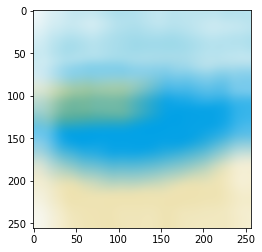

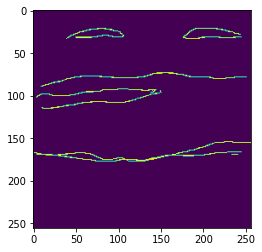

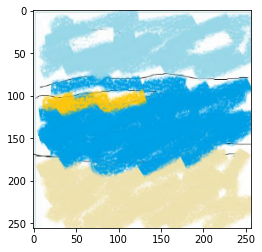

In [ ]:
plt.imshow(test_color_blur)
plt.show()
#plt.imshow(feature.canny(test_outline[:,:,0] + test_outline[:,:, sigma=2))
plt.imshow(test_outline)
plt.show()
plt.imshow(test_color)
test_color_a = test_color_blur

In [ ]:
nn_test_input = torch.from_numpy(np.array([[test_outline,test_color_a[:,:,0],test_color_a[:,:,1], test_color_a[:,:,2]]])).float().cuda() * 2 - 1

In [ ]:
nn_test_input.shape

torch.Size([1, 4, 256, 256])

In [ ]:
fake_test = Generator(nn_test_input)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


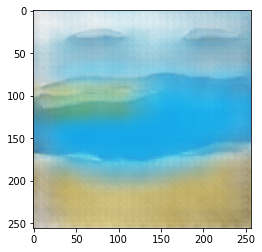

In [ ]:
plt.imshow(np.array(make_image(fake_test[0])) * 0.5 + 0.5)
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


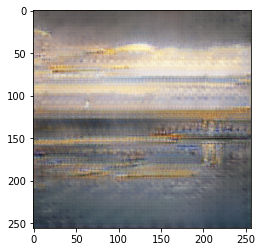

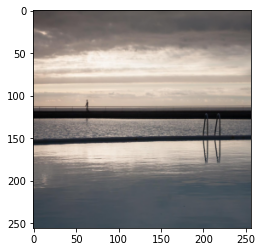

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


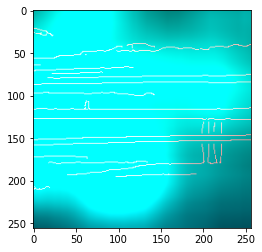

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


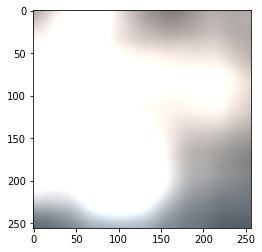

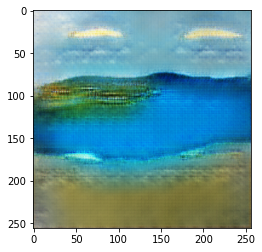

epoch :0


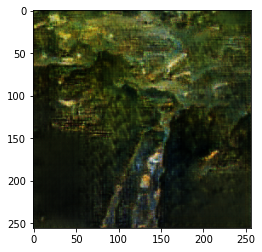

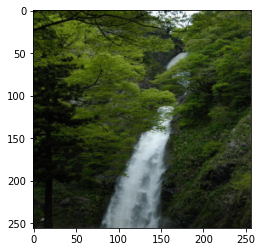

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


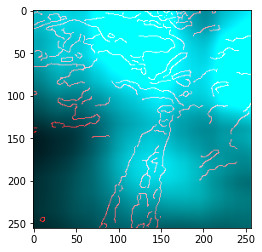

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


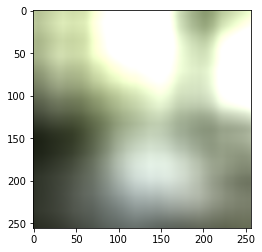

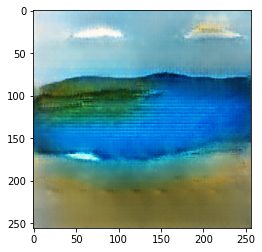

epoch :1


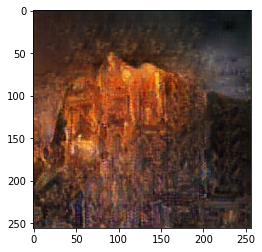

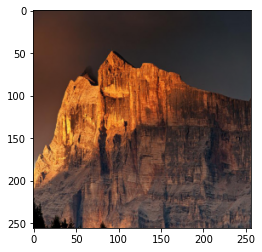

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


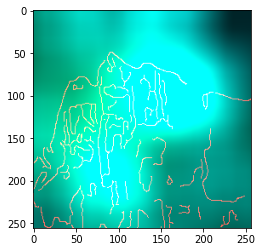

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


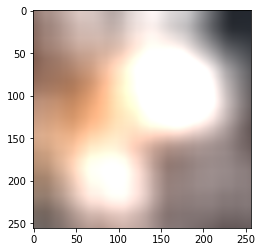

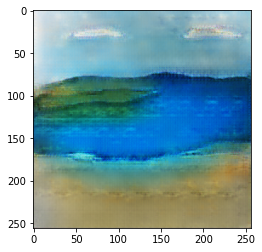

epoch :2


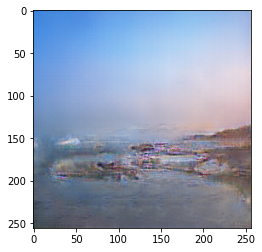

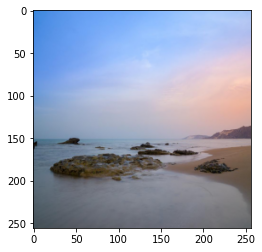

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


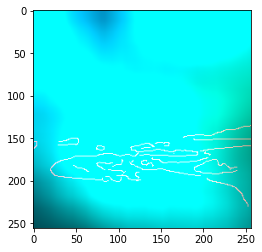

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


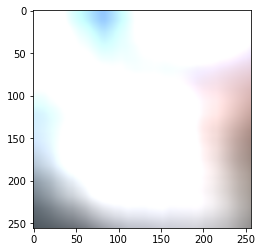

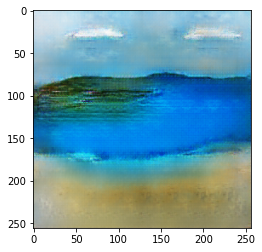

epoch :3


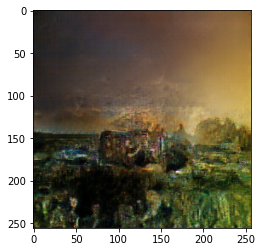

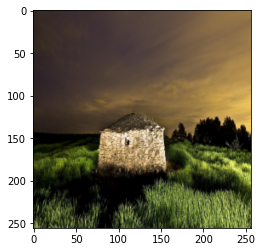

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


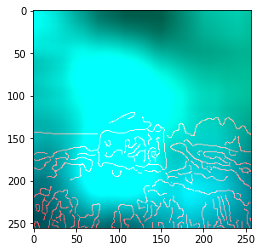

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


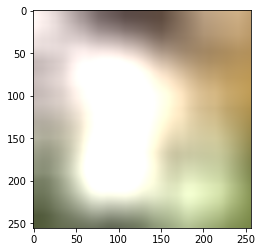

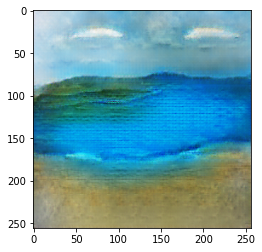

epoch :4


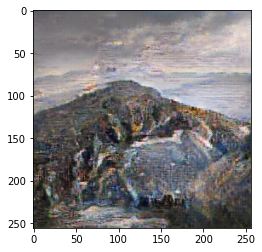

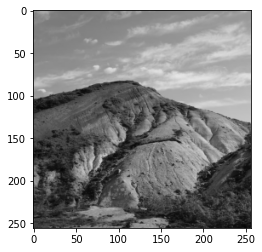

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


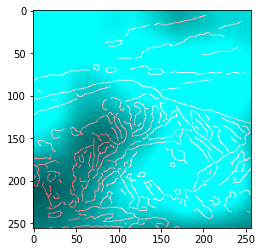

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


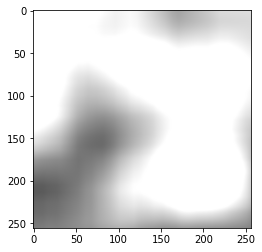

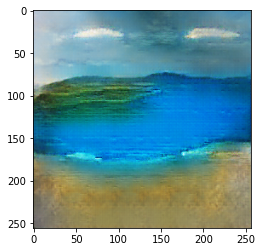

epoch :5


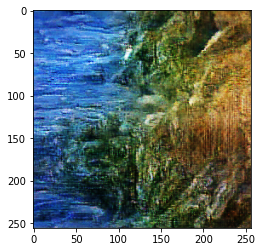

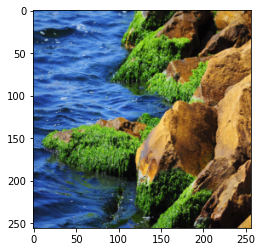

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


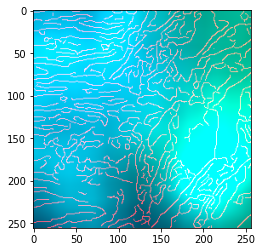

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


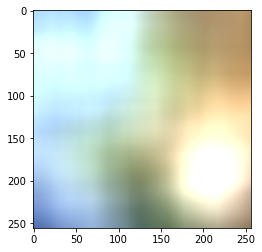

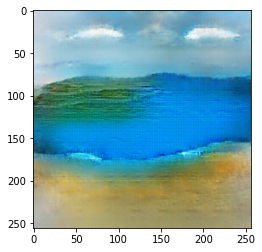

epoch :6


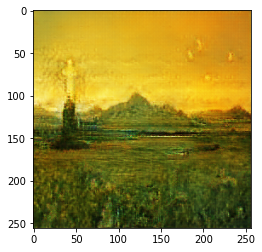

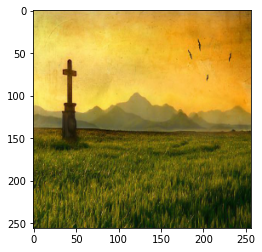

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


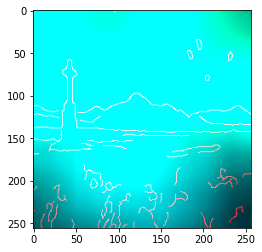

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


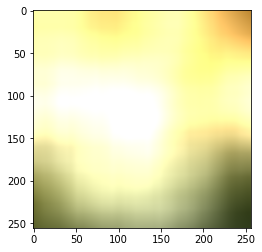

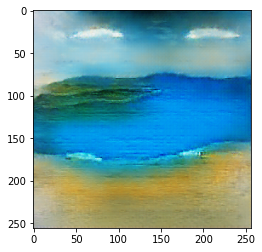

epoch :7


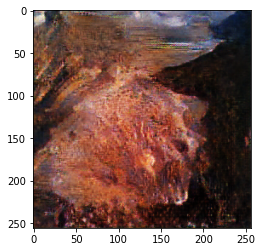

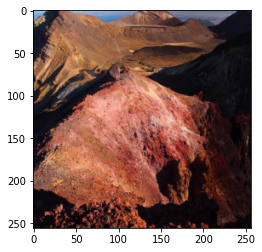

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


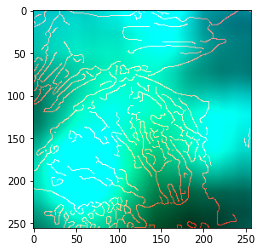

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


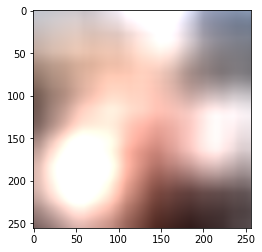

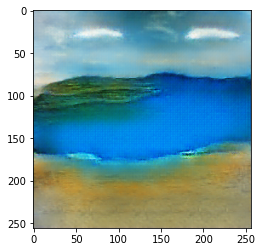

epoch :8


In [ ]:
for epoch in range(epochs):
  for batch in range(10000):
    inputs, real_images = next(iter(train_dataloader))
    inputs = inputs.cuda()
    real_images = real_images.cuda()
    fake_images = Generator(inputs)
    d_fake = Discriminator(inputs, fake_images)
    d_real = Discriminator(inputs, real_images)

    d_loss = discriminator_loss(d_fake,d_real)
    d_optimizer.zero_grad()
    d_loss.backward(retain_graph=True)
    d_optimizer.step()

    del inputs
    del real_images

    inputs, real_images = next(iter(train_dataloader))
    inputs = inputs.cuda()
    real_images = real_images.cuda()
    fake_images = Generator(inputs)
    d_fake = Discriminator(inputs, fake_images)
    d_real = Discriminator(inputs, real_images)

    g_loss = generator_loss(fake_images, real_images, d_fake)
    g_optimizer.zero_grad()
    g_loss.backward(retain_graph=True)
    g_optimizer.step()


  plt.imshow(np.array(make_image(fake_images[0])) * 0.5 + 0.5)
  plt.show()
  plt.imshow(np.array(make_image(real_images[0])) * 0.5 + 0.5)
  plt.show()
  plt.imshow(np.array(make_image(inputs[0])) * 0.5 + 0.5)
  plt.show()
  plt.imshow(np.array(make_image(inputs[0][1:])) * 0.5 + 0.5)
  plt.show()
  fake_test = Generator(nn_test_input)
  plt.imshow(np.array(make_image(fake_test[0])) * 0.5 + 0.5)
  plt.show()
  print('epoch :' + str(epoch))
  if epoch%5 == 0:
    torch.save(Generator.state_dict(), 'landscape_generator')
    torch.save(Discriminator.state_dict(), 'landscape_discriminator')

In [ ]:
torch.save(Generator.state_dict(), 'landscape_generator')
torch.save(Discriminator.state_dict(), 'landscape_discriminator')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test1_color.JPG to test1_color (6).JPG
Saving test1_outline.JPG to test1_outline (5).JPG


In [ ]:
test_color = resize(np.array(Image.open(r'/content/test1_color (6).JPG')),(256,256,3))
test_outline = resize(np.array(Image.open(r'/content/test1_outline (5).JPG')),(256,256,3))

array([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

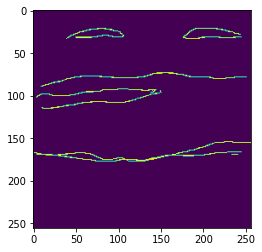

In [ ]:
test_outline = test_outline[:,:,0]*0.3+test_outline[:,:,1]*0.587+test_outline[:,:,2]*0.114
test_outline = (test_outline < 0.81).astype(int)

In [ ]:
test_color_blur = ndi.uniform_filter(test_color, size=(50, 50, 1))
test_color_blur = ndi.uniform_filter(test_color_blur, size=(100, 100, 1))

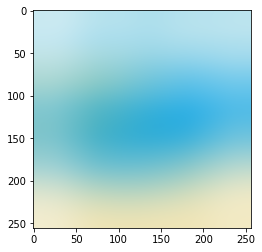

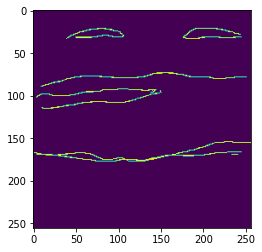

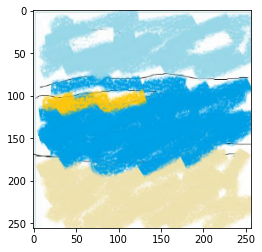

In [ ]:
plt.imshow(test_color_blur)
plt.show()
#plt.imshow(feature.canny(test_outline[:,:,0] + test_outline[:,:, sigma=2))
plt.imshow(test_outline)
plt.show()
plt.imshow(test_color)

In [ ]:
nn_test_input = torch.from_numpy(np.array([[test_outline,test_color_blur[:,:,0],test_color_blur[:,:,1], test_color_blur[:,:,2]]])).float().cuda() * 2 - 1

In [ ]:
nn_test_input.shape

torch.Size([1, 4, 256, 256])

In [ ]:
fake_test = Generator(nn_test_input)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


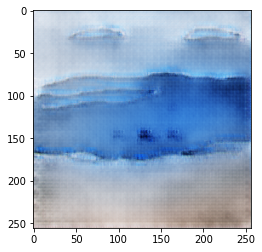

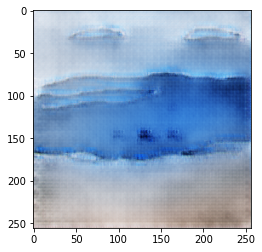

In [ ]:
plt.imshow(np.array(make_image(fake_test[0])) * 0.5 + 0.5)
plt.show()

In [ ]:
test_outline

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])